In [100]:
from pathlib import Path

import arviz as _
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib import ticker

In [86]:
plt.style.use("arviz-darkgrid")

In [64]:
pd.options.display.float_format = "{:_.8f}".format
pd.options.display.max_rows = 150

In [110]:
DADOS: Path = Path(".").parent.resolve() / "data" / "raw"
AMOSTRAS: Path = Path(".").parent.resolve() / "data" / "sample"
IMG: Path = Path(".").parent.resolve() / "img"

In [51]:
alpha = .05
z = stats.norm.ppf(1 - alpha / 2)

# Carga dos dados

In [52]:
names_map = {
    "Luiz Inácio Lula Da Silva": "Lula",
    "Jose Maria Eymael": "Eymael",
    "Constituinte Eymael": "Eymael",
    "Kelmon Luis Da Silva Souza": "Padre Kelmon",
    "Brancos": "Branco",
    "Voto Branco": "Branco",
    "Luiz Felipe Chaves D Avila": "Felipe D'Avila",
    "Soraia Thronicke": "Soraya Thronicke",
    "Soraya Vieira Thronicke": "Soraya Thronicke",
    "Ciro Ferreira Gomes": "Ciro Gomes",
    "Sofia Padua Manzano": "Sofia Manzano",
    "Jair Messias Bolsonaro": "Jair Bolsonaro",
    "Simone Nassar Tebet": "Simone Tebet",
    "Leonardo Péricles Vieira Roque": "Léo Péricles",
    "Voto Nulo": "Nulo",
    "Nulos": "Nulo",
    "Vera Lucia Pereira Da Silva Salgado": "Vera Lucia",
    "Vera": "Vera Lucia",
    "Felipe D´Avila": "Felipe D'Avila",
}

In [53]:
dfs = []

for file in DADOS.glob("*.csv"):
    cargo, turno, *_ = file.stem.split("_")
    df = (
        pd.read_csv(file, dtype="category")
        .iloc[:, -2:]
        .rename(columns=str.casefold)
        .rename(columns=lambda name: "nome" if name != "estado" else name)
        .assign(
            nome=lambda df_: df_["nome"].str.title(),
            cargo=cargo,
            turno=int(turno)
        )
        .assign(
            nome=lambda df_: df_["nome"].apply(lambda s: names_map.get(s, s))
        )
    )
    dfs.append(df)

populacao = pd.concat(dfs).astype({
    "estado": "category", "cargo": "category"
})

# Geração das amostras

In [54]:
sample_sizes = (
    pd.DataFrame([
        ['AC', 1, "Governador", 455_438, 2389],
        ['AC', 1, "Senador", 455_438, 2389],
        ['RO', 1, "Governador", 925_763, 2395],
        ['RO', 1, "Senador", 925_763, 2395],
        ['RO', 2, "Governador", 925563, 2395],
        ["AC", 1, "Presidente", 455_903, 110],
        ["RO", 1, "Presidente", 926_827, 224],
        ["AM", 1, "Presidente", 2_113_771, 512],
        ["RR", 1, "Presidente", 305_404, 74],
        ["AP", 1, "Presidente", 442_842, 107],
        ["PA", 1, "Presidente", 4_789_311, 1_159],
        ["TO", 1, "Presidente", 891_449, 216],
        ["AC", 2, "Presidente", 420_760, 104],
        ["RO", 2, "Presidente", 926_517, 230],
        ["AM", 2, "Presidente", 2_067_875, 513],
        ["RR", 2, "Presidente", 286_269, 71],
        ["AP", 2, "Presidente", 400_683, 99],
        ["PA", 2, "Presidente", 4_701_740, 1_167],
        ["TO", 2, "Presidente", 871_238, 216],

    ],
    columns=["estado", "turno", "cargo", "N", "n"])
    .set_index(["cargo", "estado", "turno"])
)
sample_sizes

N     n
cargo      estado turno               
Governador AC     1       455438  2389
Senador    AC     1       455438  2389
Governador RO     1       925763  2395
Senador    RO     1       925763  2395
Governador RO     2       925563  2395
Presidente AC     1       455903   110
           RO     1       926827   224
           AM     1      2113771   512
           RR     1       305404    74
           AP     1       442842   107
           PA     1      4789311  1159
           TO     1       891449   216
           AC     2       420760   104
           RO     2       926517   230
           AM     2      2067875   513
           RR     2       286269    71
           AP     2       400683    99
           PA     2      4701740  1167
           TO     2       871238   216

In [ ]:
random_state = 789

for (uf, turno, cargo), tamanho in sample_sizes.iterrows():
    sample = (
        populacao.query(
            f"estado == {uf!r} and turno == {turno} and cargo == {cargo!r}"
        )
        .sort_values(by="nome")
        .sample(tamanho.n, replace=False, random_state=random_state)
    )
    sample[["nome", "estado"]].to_csv(
        AMOSTRAS / f"{cargo}_{turno}_turno_{uf}.csv",
    )
    print(uf, turno, cargo, sample.shape[0])

In [56]:
dfs = []

for file in AMOSTRAS.glob("*.csv"):
    cargo, turno, *_ = file.stem.split("_")
    df = (
        pd.read_csv(file, dtype="category")
        .iloc[:, -2:]
        .rename(columns=str.casefold)
        .rename(columns=lambda name: "nome" if name != "estado" else name)
        .assign(
            nome=lambda df_: df_["nome"].str.title(),
            cargo=cargo,
            turno=int(turno)
        )
        .assign(
            nome=lambda df_: df_["nome"].apply(lambda s: names_map.get(s, s))
        )
    )
    dfs.append(df)

amostra = (
    pd.concat(dfs)
    .astype({
        "estado": "category", "cargo": "category"
    })
)

# Proporções

## Amostrais

In [65]:
proporcoes_aass = (
    amostra
    .query("cargo != 'Presidente'")
    .groupby(["cargo", "estado", "turno"])
    ["nome"].apply(lambda s: s.value_counts(normalize=True))
    .to_frame("p")
    .assign(nome=lambda df_: df_.index.get_level_values(3))
    .droplevel(3)
    .join(sample_sizes)
    .assign(
        f=lambda df_: df_["n"] / df_["N"],
        q=lambda df_: 1 - df_["p"],
        var_p=lambda df_: (1 - df_["f"]) * df_["p"] * df_["q"] / (df_["n"] - 1),
        ep_p =lambda df_: df_["var_p"].pow(.5),
        low_ci=lambda df_: df_["p"] - z * df_["ep_p"],
        upr_ci=lambda df_: df_["p"] + z * df_["ep_p"],
    )
)
proporcoes_aass

/var/folders/xs/y768pf612tscp94by_62zm040000gn/T/ipykernel_26301/1423493882.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["cargo", "estado", "turno"])


p                  nome       N     n  \
cargo      estado turno                                                  
Governador AC     1     0.53034743        Gladson Cameli  455438  2389   
                  1     0.22645458           Jorge Viana  455438  2389   
                  1     0.10590205            Mara Rocha  455438  2389   
                  1     0.06111344               Petecão  455438  2389   
                  1     0.04688154                  Nulo  455438  2389   
                  1     0.02051067                Branco  455438  2389   
                  1     0.00669736         Marcio Bittar  455438  2389   
                  1     0.00125576      Professor Nilson  455438  2389   
                  1     0.00083717            David Hall  455438  2389   
           RO     1     0.35866388  Coronel Marcos Rocha  925763  2395   
                  1     0.34906054        Marcos Rogerio  925763  2395   
                  1     0.12025052            Léo Moraes  925763  2395   
                  1     0.08475992        Daniel Pereira  925763  2395   
                  1     0.05762004                  Nulo  925763  2395   
                  1     0.02797495                Branco  925763  2395   
                  1     0.00167015   Pimenta De Rondonia  925763  2395   
                  2     0.51064718  Coronel Marcos Rocha  925563  2395   
                  2     0.43966597        Marcos Rogério  925563  2395   
                  2     0.03131524                  Nulo  925563  2395   
                  2     0.01837161                Branco  925563  2395   
Senador    AC     1     0.33654249             Alan Rick  455438  2389   
                  1     0.15864378            Ney Amorim  455438  2389   
                  1     0.15027208    Dr. Jenilson Leite  455438  2389   
                  1     0.09208874         Nazaré Araújo  455438  2389   
                  1     0.08915864         Marcia Bittar  455438  2389   
                  1     0.06697363     Dra. Vanda Milani  455438  2389   
                  1     0.06069485                  Nulo  455438  2389   
                  1     0.03976559                Branco  455438  2389   
                  1     0.00418585       Sanderson Moura  455438  2389   
                  1     0.00167434          Dimas Sandas  455438  2389   
           RO     1     0.30939457       Jaime Bagattoli  925763  2395   
                  1     0.28726514      Mariana Carvalho  925763  2395   
                  1     0.10563674      Jaqueline Cassol  925763  2395   
                  1     0.09436326       Expedito Junior  925763  2395   
                  1     0.07766180                  Nulo  925763  2395   
                  1     0.06638831          Acir Gurgacz  925763  2395   
                  1     0.04801670                Branco  925763  2395   
                  1     0.00709812      Pastor Josinelio  925763  2395   
                  1     0.00417537  Dra Rosangela Lázaro  925763  2395   

                                 f          q      var_p       ep_p  \
cargo      estado turno                                               
Governador AC     1     0.00524550 0.46965257 0.00010376 0.01018613   
                  1     0.00524550 0.77354542 0.00007297 0.00854229   
                  1     0.00524550 0.89409795 0.00003944 0.00628037   
                  1     0.00524550 0.93888656 0.00002390 0.00488895   
                  1     0.00524550 0.95311846 0.00001861 0.00431435   
                  1     0.00524550 0.97948933 0.00000837 0.00289288   
                  1     0.00524550 0.99330264 0.00000277 0.00166469   
                  1     0.00524550 0.99874424 0.00000052 0.00072280   
                  1     0.00524550 0.99916283 0.00000035 0.00059029   
           RO     1     0.00258706 0.64133612 0.00009584 0.00978954   
                  1     0.00258706 0.65093946 0.00009467 0.00972963   
                  1     0.00258706 0.87974948 0.00004408 0.00663894   
    

In [66]:
proporcao_estrato = (
    amostra
    .query("cargo == 'Presidente'")
    .groupby(["cargo", "estado", "turno"])
    ["nome"]
    .apply(lambda s: s.value_counts(normalize=True))
    .to_frame("ph")
    .assign(
        nome=lambda df_: df_.index.get_level_values(-1)
    )
    .droplevel(-1)
    .join(sample_sizes)
    .assign(
        f=lambda df_: df_["n"] / df_["N"],
        qh=lambda df_: 1 - df_["ph"],
        var_ph=lambda df_: (1 - df_["f"]) * df_["ph"] * df_["qh"] / (df_["n"] - 1),
    )
)
proporcao_estrato

/var/folders/xs/y768pf612tscp94by_62zm040000gn/T/ipykernel_26301/3714606991.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["cargo", "estado", "turno"])


ph              nome        N     n  \
cargo      estado turno                                               
Presidente AC     1     0.68181818    Jair Bolsonaro   455903   110   
                  1     0.25454545              Lula   455903   110   
                  1     0.02727273        Ciro Gomes   455903   110   
                  1     0.01818182            Branco   455903   110   
                  1     0.00909091      Simone Tebet   455903   110   
                  1     0.00909091    Felipe D'Avila   455903   110   
                  2     0.74038462    Jair Bolsonaro   420760   104   
                  2     0.23076923              Lula   420760   104   
                  2     0.01923077              Nulo   420760   104   
                  2     0.00961538            Branco   420760   104   
           AM     1     0.46679688              Lula  2113771   512   
                  1     0.43164062    Jair Bolsonaro  2113771   512   
                  1     0.04101562      Simone Tebet  2113771   512   
                  1     0.02343750              Nulo  2113771   512   
                  1     0.01562500        Ciro Gomes  2113771   512   
                  1     0.00976562            Branco  2113771   512   
                  1     0.00781250  Soraya Thronicke  2113771   512   
                  1     0.00390625      Padre Kelmon  2113771   512   
                  2     0.50682261              Lula  2067875   513   
                  2     0.46198830    Jair Bolsonaro  2067875   513   
                  2     0.02534113              Nulo  2067875   513   
                  2     0.00584795            Branco  2067875   513   
           AP     1     0.50467290              Lula   442842   107   
                  1     0.37383178    Jair Bolsonaro   442842   107   
                  1     0.06542056      Simone Tebet   442842   107   
                  1     0.03738318        Ciro Gomes   442842   107   
                  1     0.01869159              Nulo   442842   107   
                  2     0.48484848    Jair Bolsonaro   400683    99   
                  2     0.48484848              Lula   400683    99   
                  2     0.02020202              Nulo   400683    99   
                  2     0.01010101            Branco   400683    99   
           PA     1     0.50819672              Lula  4789311  1159   
                  1     0.39344262    Jair Bolsonaro  4789311  1159   
                  1     0.04141501      Simone Tebet  4789311  1159   
                  1     0.02502157        Ciro Gomes  4789311  1159   
                  1     0.01639344              Nulo  4789311  1159   
                  1     0.01035375            Branco  4789311  1159   
                  1     0.00345125  Soraya Thronicke  4789311  1159   
                  1     0.00172563    Felipe D'Avila  4789311  1159   
                  2     0.55526992              Lula  4701740  1167   
                  2     0.41388175    Jair Bolsonaro  4701740  1167   
                  2     0.01885176              Nulo  4701740  1167   
                  2     0.01199657            Branco  4701740  1167   
           RO     1     0.67857143    Jair Bolsonaro   926827   224   
                  1     0.23214286              Lula   926827   224   
                  1     0.04910714      Simone Tebet   926827   224   
                  1     0.02232143        Ciro Gomes   926827   224   
                  1     0.00892857    Felipe D'Avila   926827   224   
                  1     0.00446429            Branco   926827   224   
                  1     0.00446429              Nulo   926827   224   
                  2     0.67391304    Jair Bolsonaro   926517   230   
                  2     0.28260870              Lula   926517   230   
                  2     0.02608696            Branco   926517   230   
                  2     0.01739130              Nulo   926517   230   
           RR     1     0.72972973    Jair Bolsonaro   3

In [67]:
peso_estrato = (
    sample_sizes
    .query("cargo == 'Presidente'")
    .groupby("turno", as_index=False)
    ["N"].apply(lambda s: s / s.sum())
    .to_frame("Wh")
    .droplevel(0)
)

In [127]:
aas_regiao = (
    proporcao_estrato
    .join(peso_estrato)
    .assign(
        wh2varph=lambda df_: df_["Wh"].pow(2) * df_["var_ph"],
        whph=lambda df_: df_["Wh"] * df_["ph"],
    )
    .groupby(["nome", "turno"])
    .agg({
        "wh2varph": pd.Series.sum,
        "whph": pd.Series.sum
    })
    .rename(columns={
        "wh2varph": "var_p",
        "whph": "p"
    })
    .assign(
        ep_p =lambda df_: df_["var_p"].pow(.5),
        low_ci=lambda df_: df_["p"] - z * df_["ep_p"],
        upr_ci=lambda df_: df_["p"] + z * df_["ep_p"],
    )
)
aas_regiao

var_p          p       ep_p      low_ci     upr_ci
nome             turno                                                        
Branco           1     0.00000412 0.00999090 0.00203065  0.00601090 0.01397090
                 2     0.00000463 0.01124825 0.00215208  0.00703024 0.01546625
Ciro Gomes       1     0.00000983 0.02414830 0.00313498  0.01800386 0.03029274
Felipe D'Avila   1     0.00000104 0.00249977 0.00101949  0.00050160 0.00449794
Jair Bolsonaro   1     0.00009825 0.44967990 0.00991213  0.43025249 0.46910732
                 2     0.00009887 0.48046300 0.00994335  0.46097438 0.49995162
Lula             1     0.00009879 0.45124266 0.00993956  0.43176148 0.47072383
                 2     0.00009884 0.48620420 0.00994162  0.46671899 0.50568942
Nulo             1     0.00000681 0.01664724 0.00260986  0.01153201 0.02176248
                 2     0.00000901 0.02208455 0.00300205  0.01620064 0.02796846
Padre Kelmon     1     0.00000052 0.00124769 0.00071980 -0.00016309 0.00265848
Simone Tebet     1     0.00001645 0.04121444 0.00405550  0.03326582 0.04916307
Soraya Thronicke 1     0.00000138 0.00332909 0.00117438  0.00102735 0.00563084

## Populacionais

In [75]:
pop_estatuais = (
    populacao
    .query("cargo != 'Presidente' and estado in ['RO', 'AC']")
    .groupby(["cargo", "estado", "turno"])
    ["nome"].apply(lambda s: s.value_counts(normalize=True))
    .to_frame("P")
)
pop_estatuais

/var/folders/xs/y768pf612tscp94by_62zm040000gn/T/ipykernel_26301/4203168705.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["cargo", "estado", "turno"])


P
cargo      estado turno                                
Governador AC     1     Gladson Cameli       0.53157620
                        Jorge Viana          0.22673778
                        Mara Rocha           0.10357722
                        Petecão              0.06014650
                        Nulo                 0.04627853
                        Branco               0.01704074
                        Marcio Bittar        0.01048002
                        Professor Nilson     0.00247015
                        David Hall           0.00169288
           RO     1     Coronel Marcos Rocha 0.35717133
                        Marcos Rogerio       0.34029768
                        Léo Moraes           0.12917237
                        Daniel Pereira       0.08795016
                        Nulo                 0.04822293
                        Branco               0.03323205
                        Pimenta De Rondonia  0.00395350
                  2     Coronel Marcos Rocha 0.49523371
                        Marcos Rogério       0.44867610
                        Nulo                 0.03437043
                        Branco               0.02171975
Senador    AC     1     Alan Rick            0.33882109
                        Ney Amorim           0.16153022
                        Dr. Jenilson Leite   0.14386590
                        Marcia Bittar        0.09037234
                        Nazaré Araújo        0.08685046
                        Dra. Vanda Milani    0.07609817
                        Nulo                 0.05845362
                        Branco               0.03703468
                        Sanderson Moura      0.00606669
                        Dimas Sandas         0.00090682
           RO     1     Jaime Bagattoli      0.31702282
                        Mariana Carvalho     0.28469381
                        Jaqueline Cassol     0.11236137
                        Expedito Junior      0.09067764
                        Acir Gurgacz         0.06837603
                        Nulo                 0.06116468
                        Branco               0.05338407
                        Pastor Josinelio     0.00822781
                        Dra Rosangela Lázaro 0.00409176

In [137]:
pop_regiao = (
    populacao
    .query("cargo == 'Presidente'")
    .groupby(["cargo", "turno"])
    ["nome"]
    .apply(lambda s: s.value_counts(normalize=True))
    .to_frame("P")
    .unstack("turno")
)
pop_regiao

/var/folders/xs/y768pf612tscp94by_62zm040000gn/T/ipykernel_26301/884266463.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["cargo", "turno"])


P           
turno                                1          2
cargo                                            
Presidente Branco           0.00970590 0.00942752
           Ciro Gomes       0.02342258        NaN
           Eymael           0.00010700        NaN
           Felipe D'Avila   0.00181401        NaN
           Jair Bolsonaro   0.44291360 0.49438392
           Lula             0.45910471 0.47471680
           Léo Péricles     0.00019203        NaN
           Nulo             0.01541916 0.02147176
           Padre Kelmon     0.00061921        NaN
           Simone Tebet     0.04113684        NaN
           Sofia Manzano    0.00022125        NaN
           Soraya Thronicke 0.00515510        NaN
           Vera Lucia       0.00018860        NaN

### Gráficos

/var/folders/xs/y768pf612tscp94by_62zm040000gn/T/ipykernel_26301/162223156.py:41: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
/var/folders/xs/y768pf612tscp94by_62zm040000gn/T/ipykernel_26301/162223156.py:41: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
/var/folders/xs/y768pf612tscp94by_62zm040000gn/T/ipykernel_26301/162223156.py:41: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
/var/folders/xs/y768pf612tscp94by_62zm040000gn/T/ipykernel_26301/162223156.py:41: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
/var/folders/xs/y768pf612tscp94by_62zm040000gn/T/ipykernel_26301/162223156.py:41: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


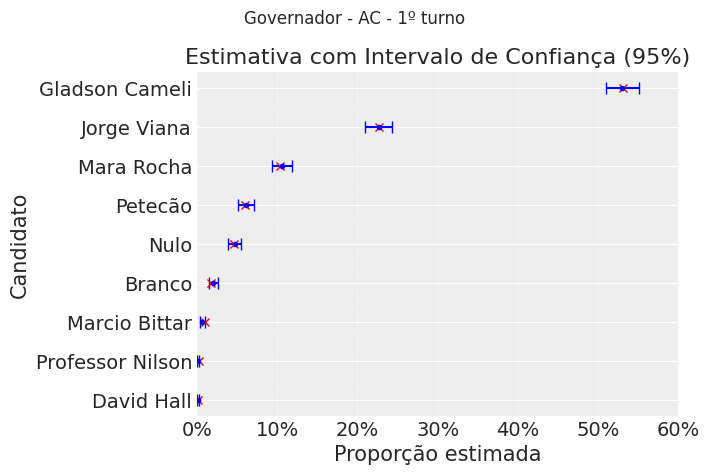

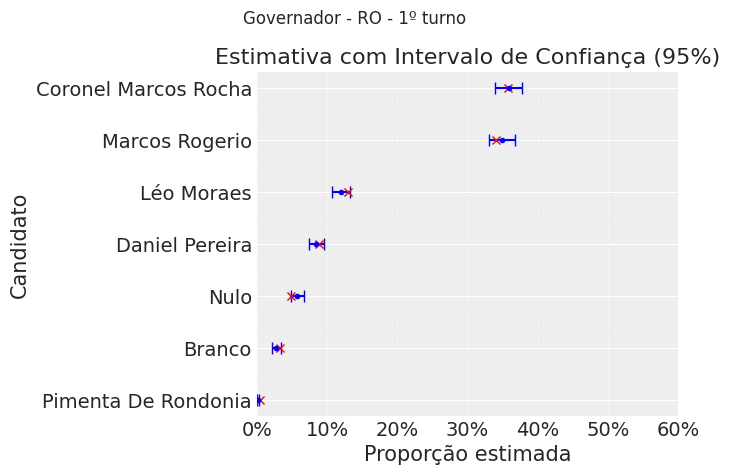

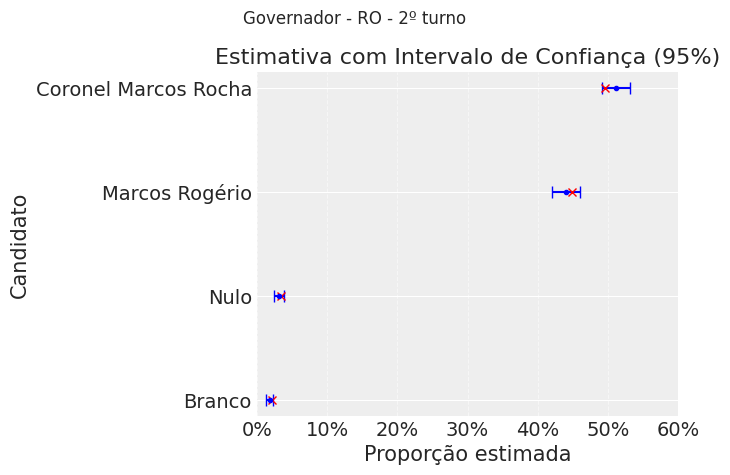

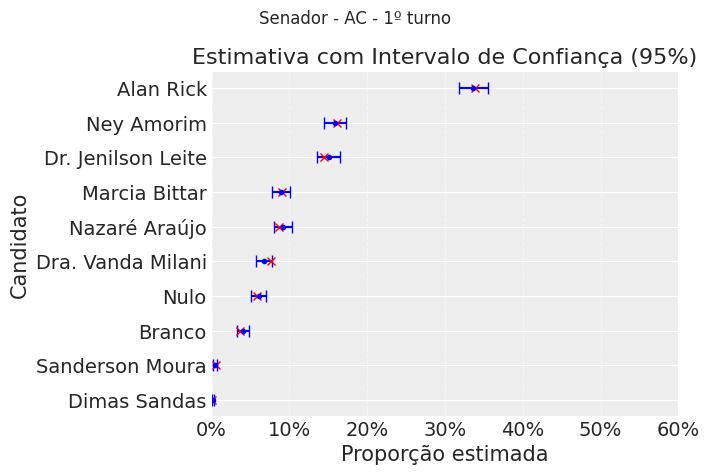

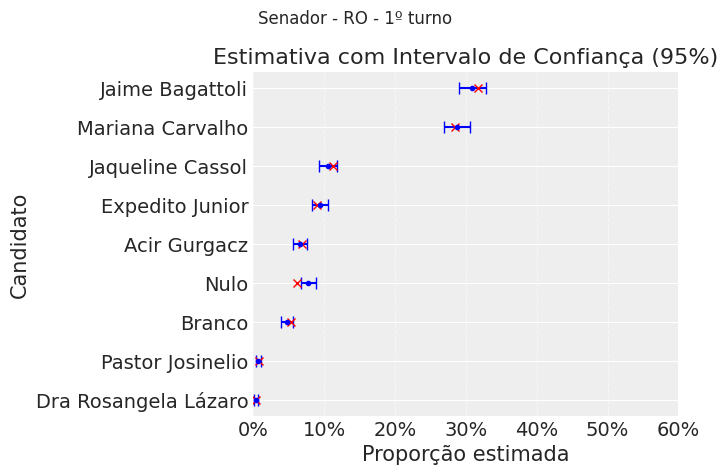

In [144]:
for idx in proporcoes_aass.index.unique():
    cargo, estado, turno = idx
    fig, ax = plt.subplots()

    df_plot_amostra = proporcoes_aass.loc[idx, :].reset_index()
    df_plot_pop = pop_estatuais.loc[idx, :].reset_index().sort_values("P")

    df_plot_amostra["erro_inf"] = df_plot_amostra["p"] - df_plot_amostra["low_ci"]
    df_plot_amostra["erro_sup"] = df_plot_amostra["upr_ci"] - df_plot_amostra["p"]

    # Ordenar por proporção (opcional)
    ax.errorbar(
        x=df_plot_pop["P"],
        y=df_plot_pop["index"],
        color="red",
        fmt="x",
        markersize=6,
    )

    ax.errorbar(
        x=df_plot_amostra["p"],
        y=df_plot_amostra["nome"],  # eixo y = nomes
        xerr=[df_plot_amostra["erro_inf"], df_plot_amostra["erro_sup"]],
        fmt='o',
        color='blue',
        ecolor='blue',
        capsize=4,
        markersize=3,
        linestyle='none'
    )

    fig.suptitle(f"{cargo} - {estado} - {turno}º turno")
    ax.set_xlabel("Proporção estimada")
    ax.set_ylabel("Candidato")
    ax.set_title("Estimativa com Intervalo de Confiança (95%)")

    ax.set_xlim(0, .6)
    ax.grid(axis='x', linestyle='--', alpha=0.5)
    ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))

    fig.tight_layout()
    fig.savefig(IMG / f"{cargo}_{estado}_{turno}.png")

/var/folders/xs/y768pf612tscp94by_62zm040000gn/T/ipykernel_26301/3930398455.py:8: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  .stack("turno")
/var/folders/xs/y768pf612tscp94by_62zm040000gn/T/ipykernel_26301/3930398455.py:47: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
/var/folders/xs/y768pf612tscp94by_62zm040000gn/T/ipykernel_26301/3930398455.py:8: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  .stack("turno")
/var/folders/xs/y768pf612tscp94by_62zm040000gn/T/ipykernel_26301/3930398455.py:47: UserWarning: The figure layout has changed to tig

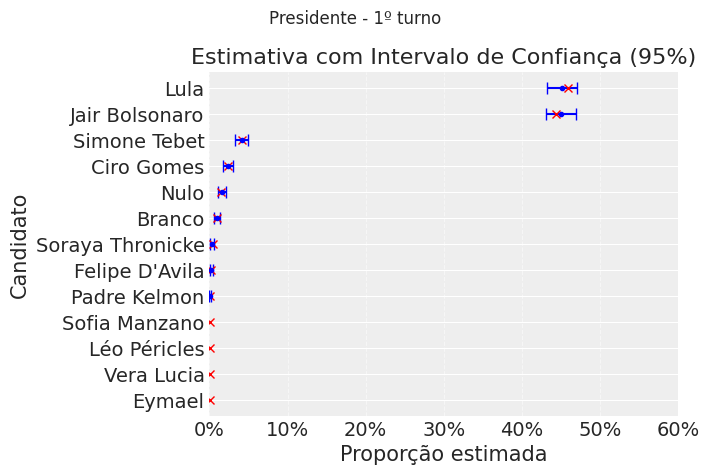

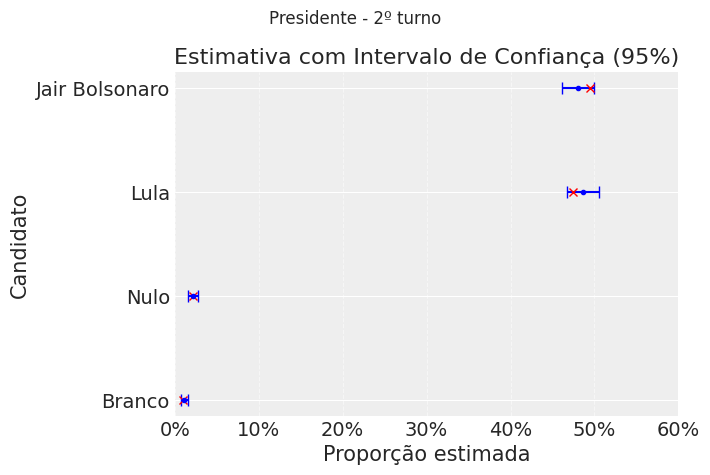

In [146]:
for turno in aas_regiao.index.get_level_values(-1).unique():
    cargo = "Presidente"
    fig, ax = plt.subplots()

    df_plot_amostra = aas_regiao.reset_index().loc[lambda df: df["turno"] == turno, :]
    df_plot_pop = (
        pop_regiao
        .stack("turno")
        .reset_index()
        .loc[lambda df: df["turno"] == turno, :]
        .sort_values("P")
    )

    df_plot_amostra["erro_inf"] = df_plot_amostra["p"] - df_plot_amostra["low_ci"]
    df_plot_amostra["erro_sup"] = df_plot_amostra["upr_ci"] - df_plot_amostra["p"]

    # Ordenar por proporção (opcional)
    ax.errorbar(
        x=df_plot_pop["P"],
        y=df_plot_pop["level_1"],
        color="red",
        fmt="x",
        markersize=6,
    )

    ax.errorbar(
        x=df_plot_amostra["p"],
        y=df_plot_amostra["nome"],  # eixo y = nomes
        xerr=[df_plot_amostra["erro_inf"], df_plot_amostra["erro_sup"]],
        fmt='o',
        color='blue',
        ecolor='blue',
        capsize=4,
        markersize=3,
        linestyle='none'
    )

    fig.suptitle(f"{cargo} - {turno}º turno")
    ax.set_xlabel("Proporção estimada")
    ax.set_ylabel("Candidato")
    ax.set_title("Estimativa com Intervalo de Confiança (95%)")

    ax.set_xlim(0, .6)
    ax.grid(axis='x', linestyle='--', alpha=0.5)
    ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))

    fig.tight_layout()
    fig.savefig(IMG / f"{cargo}_{turno}.png")

In [168]:
# Loop para cada combinação de cargo, estado e turno
for idx in proporcoes_aass.index.unique():
    cargo, estado, turno = idx
    fig, ax = plt.subplots()

    # Preparar os dados
    df_plot_amostra = proporcoes_aass.loc[idx, :].reset_index()
    df_plot_pop = pop_estatuais.loc[idx, :].reset_index().sort_values("P")

    # Definir erro fixo de 2 pontos percentuais (0.02)
    erro_fixo = 0.02

    # Calcular limites superior e inferior com truncamento
    df_plot_amostra["erro_inf"] = (df_plot_amostra["p"] - erro_fixo).clip(lower=0)
    df_plot_amostra["erro_sup"] = (df_plot_amostra["p"] + erro_fixo).clip(upper=1)

    # Calcular o erro absoluto para plotar no gráfico
    xerr = [
        df_plot_amostra["p"] - df_plot_amostra["erro_inf"],
        df_plot_amostra["erro_sup"] - df_plot_amostra["p"]
    ]

    # Plotar valores populacionais (vermelho)
    ax.errorbar(
        x=df_plot_pop["P"],
        y=df_plot_pop["index"],  # ou df_plot_pop["nome"] se preferir
        color="red",
        fmt="x",
        markersize=6,
    )

    # Plotar estimativas amostrais com intervalo fixo (azul)
    ax.errorbar(
        x=df_plot_amostra["p"],
        y=df_plot_amostra["nome"],  # eixo y com nomes dos candidatos
        xerr=xerr,
        fmt='o',
        color='blue',
        ecolor='blue',
        capsize=4,
        markersize=3,
        linestyle='none'
    )

    # Títulos e legendas
    fig.suptitle(f"{cargo} - {estado} - {turno}º turno")
    ax.set_title("Estimativa com Intervalo de Confiança Fixo (±2pp)")
    ax.set_xlabel("Proporção estimada")
    ax.set_ylabel("Candidato")

    # Formatação do gráfico
    ax.set_xlim(0, 0.6)
    ax.grid(axis='x', linestyle='--', alpha=0.5)
    ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))

    # Ajuste e salvamento
    fig.tight_layout()
    fig.savefig(IMG / f"{cargo}_{estado}_{turno}_conservativa.png")
    plt.close(fig)

/var/folders/xs/y768pf612tscp94by_62zm040000gn/T/ipykernel_26301/401428835.py:57: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
/var/folders/xs/y768pf612tscp94by_62zm040000gn/T/ipykernel_26301/401428835.py:57: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
/var/folders/xs/y768pf612tscp94by_62zm040000gn/T/ipykernel_26301/401428835.py:57: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
/var/folders/xs/y768pf612tscp94by_62zm040000gn/T/ipykernel_26301/401428835.py:57: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
/var/folders/xs/y768pf612tscp94by_62zm040000gn/T/ipykernel_26301/401428835.py:57: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


In [169]:
erro_fixo = 0.02  # 2 pontos percentuais

for turno in aas_regiao.index.get_level_values(-1).unique():
    cargo = "Presidente"
    fig, ax = plt.subplots()

    # Filtrar dados da amostra para o turno
    df_plot_amostra = aas_regiao.reset_index().loc[lambda df: df["turno"] == turno, :]

    # Filtrar e organizar dados da população
    df_plot_pop = (
        pop_regiao
        .stack("turno")
        .reset_index()
        .loc[lambda df: df["turno"] == turno, :]
        .sort_values("P")
    )

    # Calcular ICs fixos truncados entre 0 e 1
    df_plot_amostra["erro_inf"] = (df_plot_amostra["p"] - erro_fixo).clip(lower=0)
    df_plot_amostra["erro_sup"] = (df_plot_amostra["p"] + erro_fixo).clip(upper=1)

    # Calcular erro absoluto para xerr
    xerr = [
        df_plot_amostra["p"] - df_plot_amostra["erro_inf"],
        df_plot_amostra["erro_sup"] - df_plot_amostra["p"]
    ]

    # Plotar dados populacionais (vermelhos)
    ax.errorbar(
        x=df_plot_pop["P"],
        y=df_plot_pop["level_1"],  # Região ou similar
        color="red",
        fmt="x",
        markersize=6,
    )

    # Plotar estimativas amostrais com IC fixo (azul)
    ax.errorbar(
        x=df_plot_amostra["p"],
        y=df_plot_amostra["nome"],
        xerr=xerr,
        fmt='o',
        color='blue',
        ecolor='blue',
        capsize=4,
        markersize=3,
        linestyle='none'
    )

    # Títulos e rótulos
    fig.suptitle(f"{cargo} - {turno}º turno")
    ax.set_xlabel("Proporção estimada")
    ax.set_ylabel("Candidato")
    ax.set_title("Estimativa com Intervalo de Confiança Fixo (±2pp)")

    ax.set_xlim(0, 0.6)
    ax.grid(axis='x', linestyle='--', alpha=0.5)
    ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))

    fig.tight_layout()
    fig.savefig(IMG / f"{cargo}_{turno}_conservativa.png")
    plt.close(fig)

/var/folders/xs/y768pf612tscp94by_62zm040000gn/T/ipykernel_26301/4023368430.py:13: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  .stack("turno")
/var/folders/xs/y768pf612tscp94by_62zm040000gn/T/ipykernel_26301/4023368430.py:61: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
/var/folders/xs/y768pf612tscp94by_62zm040000gn/T/ipykernel_26301/4023368430.py:13: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  .stack("turno")
/var/folders/xs/y768pf612tscp94by_62zm040000gn/T/ipykernel_26301/4023368430.py:61: UserWarning: The figure layout has changed to t